In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model


In [3]:
rawdata = pd.read_csv('datasets/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013_clean.csv')
vadata = pd.read_excel('datasets/table_8_offenses_known_to_law_enforcement_virginia_by_city_2013.xls')

rawdata = rawdata.drop(range(len(rawdata.index)-3, len(rawdata.index)))
vadata = vadata.drop([len(vadata.index)-2, len(vadata.index)-1])
vadata = vadata.drop(range(0,4))

colnames = ['city','population','violentcrime','murder','revisedrape','legacyrape','robbery','aggravatedassault','propertycrime','burglary','larceny','autotheft','arson']
rawdata.columns = colnames
vadata.columns = colnames

In [4]:
filleddata = rawdata.fillna(value='0')
vadata = vadata.fillna(value='0')

In [5]:
#replace all these freaking strings with ints by removing the commas
def remove_commas(x):
    return str(x).replace(',','')

filleddata = filleddata.applymap(remove_commas)
vadata = vadata.applymap(remove_commas)

In [6]:
#change the data type of all the numerical data to a float
def makefloat(x):
    if str(x).isdigit():
        return float(x)
    else:
        return(x)

filleddata = filleddata.applymap(makefloat)
vadata = vadata.applymap(makefloat)

In [7]:
filleddata['popsquared'] = filleddata['population']**2
vadata['popsquared'] = vadata['population']**2

In [8]:
filleddata.murder = filleddata.murder.astype(float)
filleddata.robbery = filleddata.robbery.astype(float)

In [9]:
murderbools = []
robberybools = []

for val in filleddata['murder']:
    murderbools.append(val > 0)
for val in filleddata['robbery']:
    robberybools.append(val > 0)
filleddata['murderbool'] = murderbools 
filleddata['robberybool'] = robberybools

In [10]:
murderbools = []
robberybools = []
for val in vadata['murder']:
    murderbools.append(val > 0)
for val in vadata['robbery']:
    robberybools.append(val > 0)
vadata['murderbool'] = murderbools 
vadata['robberybool'] = robberybools

In [32]:
def propcrimefeatures(df):
    return df[['population', 'burglary', 'larceny']]

In [37]:
#independent variables
ind = propcrimefeatures(filleddata)
vaind = propcrimefeatures(vadata)

#dependent variable
dep = filleddata['propertycrime'].values.reshape(-1, 1)
vadep = vadata['propertycrime'].values.reshape(-1,1)

regmodel = linear_model.LinearRegression()
regmodel.fit(ind, dep)
vamodel = linear_model.LinearRegression()
vamodel.fit(vaind, vadep)

print('Coefficients: ', regmodel.coef_)
print('Intercept: ', regmodel.intercept_)
print('R-squared: ', regmodel.score(ind, dep))
print('')
print('VA Coefficients: ', vamodel.coef_)
print('Intercept: ', vamodel.intercept_)
print('R-Squared: ', vamodel.score(vaind, vadep))

Coefficients:  [[8.55207769e-04 1.27302639e+00 9.63743271e-01]]
Intercept:  [-7.91602578]
R-squared:  0.9999968758418633

VA Coefficients:  [[2.12663205e-06 1.27192823e+00 1.01776016e+00]]
Intercept:  [-3.40049237]
R-Squared:  0.9993910487786345


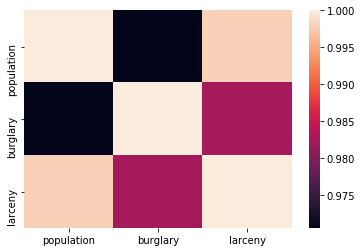

In [12]:
heatmap = ind.astype(float).corr()

sns.heatmap(heatmap, xticklabels=heatmap.columns, yticklabels=heatmap.columns)

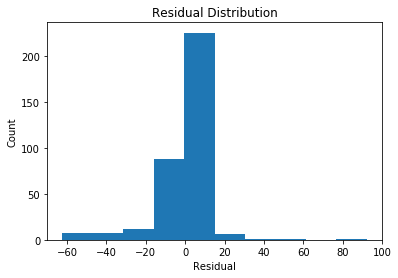

In [13]:
predictions = regmodel.predict(ind).ravel()
residual = filleddata['propertycrime'] - predictions

plt.hist(residual)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

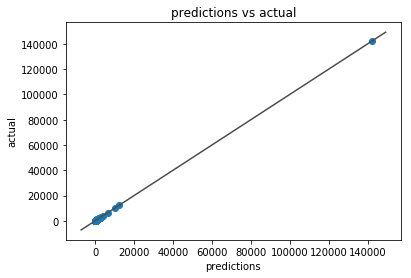

In [14]:
f, ax = plt.subplots()
plt.scatter(predictions, filleddata['propertycrime'])
plt.title('predictions vs actual')
plt.xlabel('predictions')
plt.ylabel('actual')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c=".3")
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

trainfeatures, testfeatures, trainresults, testresults = train_test_split(ind, dep, test_size = .2)

print('Testing the model on the full dataset: ' + str(regmodel.fit(ind, dep).score(ind, dep)))
print('Testing the model on the heldout dataset: '+str(regmodel.fit(trainfeatures, trainresults).score(testfeatures, testresults)))


Testing the model on the full dataset: 0.9999968758418633
Testing the model on the heldout dataset: 0.9996835515150326


To begin with, the goal of the assignment was to predict the amount of property crime in each city, so I just picked features that seemed like they would be correlated with 'property crime,' to be honest, and I figured I would refine the model from there. However, somehow it made a perfect line through all the data points. It turns out that propertycrime is actually calculated by summing 4 of the other columns of the data table, 3 of which were included as features. The 4th column consisted of all 0s, so it had no impact anyway. In any case though, after creating this preliminary model, it turned out that all of the features were extremely highly correlated with each other as well as the result value. I ended up removing all of the features besides "population" since the other features were extraneous, and still retained an R^2 value greater than .99.

So it turns out using just population for the model leads to gross overfitting. So I added a couple of other features that seemed to be prominently correlated with property crime. This improved the R^2 value when it was subjected to holdout tests, so this model is way better at predicting property crime.